# Multiple-objective portfolio optimization

# INTRODUCTION

Your task is to solve a multiple-objective portfolio optimization problem.
-  Use the basic Markowitz's model from 1952 (see Lecture 1)
-  Solve = construct Pareto front approximations.
-  The dataset is the same as for the portfolio game part 1 (bundle1.zip).
-  The dataset consists of the historical prices of 20 assets.
-  The bundle contains 20 files (*.txt) linked to different assets.
-  The name of the file suggests the asset's name.
-  The structure of every file is as follows:
1.  The first line contains the name of the asset.
2. The second line provides the number of data points N.
3. The following N lines are data points with the structure: time, price.
-  The historical timeline for all assets is time $\in$ [0,100].
-  Future predictions should be calculated for time = 200.

Goal: 
-  Load data, make predictions, and build the model. 
-  Illustrate your predictions (can be done in the jupyter notebook)
-  Then, implement the WSM and ECM methods (see the tutorial on quadratic programming provided below). 
-  Run your implementations for different calculation limits (e.g., the number of weight vectors for WSM). Compare the methods' efficiency in finding unique Pareto optimal solutions. Finally, illustrate generated Pareto fronts.

# Short tutorial on the cvxopt library for quadratic programming

In [22]:
import numpy as np
from cvxopt import matrix, solvers

# QP Optimization Problem

### General model:

$max$ $\boldsymbol{cx} - \dfrac{1}{2}\boldsymbol{x}^T\boldsymbol{Qx}$ <br>
$s.t.$ <br>
$\boldsymbol{Gx} \leq \boldsymbol{h}$ <br>
$\boldsymbol{x} \geq \boldsymbol{0}$

### But the library uses the following form:

$min$ $\boldsymbol{cx} + \dfrac{1}{2}\boldsymbol{x}^T\boldsymbol{Qx}$ <br>
$s.t.$ <br>
$\boldsymbol{Gx} \leq \boldsymbol{h}$ <br>
$\boldsymbol{Ax} = \boldsymbol{b}$ <br>

### Exmple

$min$ $2x^2_1+x_2^2+x_1x_2+x_1+x_2$ <br>
$s.t.$ <br>
$x_1 \geq 0$<br>
$x_2 \geq 0$<br>
$x_1 + x_2 = 1$<br>

### Hence:

In [23]:
Q = matrix([ [4.0, 1.0], [1.0, 2.0] ]) ## [4, 1] is 1st column, not row!

In [24]:
c = matrix([1.0, 1.0]) ### (1, 2) = dimensions (1 row and 2 columns)

In [25]:
A = matrix([1.0, 1.0], (1,2)) ### (1, 2) = dimensions (1 row and 2 columns)

In [26]:
b = matrix(1.0) 

In [27]:
G = matrix([[-1.0,0.0],[0.0,-1.0]]) ### multiplied both sides by -1

In [28]:
h = matrix([0.0,0.0]) ### multiplied both sides by -1

In [29]:
solQP=solvers.qp(Q, c, G, h, A, b)

In [30]:
print(solQP.keys())

dict_keys(['x', 'y', 's', 'z', 'status', 'gap', 'relative gap', 'primal objective', 'dual objective', 'primal infeasibility', 'dual infeasibility', 'primal slack', 'dual slack', 'iterations'])


In [31]:
print(solQP['x'])
print(solQP['primal objective'])

[ 2.50e-01]
[ 7.50e-01]

1.8750000000000182


# We can also solve LP problems:

$min$ $\boldsymbol{c}\boldsymbol{x}$ <br>
$s.t.$ <br>
$\boldsymbol{Gx} \leq \boldsymbol{h}$ <br>
$\boldsymbol{Ax} = \boldsymbol{b}$ (optional)

### Exmple

$min$ $2x_1+x_2$ <br>
$s.t.$ <br>
$-x_1 +x_2 \leq 1$ <br>
$x_1 + x_2 \geq 2$ <br>
$x_2 \geq 0$<br>
$x_1 - 2x_2 \leq 4$

In [32]:
G = matrix([ [-1.0, -1.0, 0.0, 1.0], [1.0, -1.0, -1.0, -2.0] ])
h = matrix([ 1.0, -2.0, 0.0, 4.0 ])
c = matrix([ 2.0, 1.0 ])
solLP = solvers.lp(c,G,h)  
###!!!! OPTIONALLY A and b can be provided (equality constraints) as in solQP=solvers.qp(Q, c, G, h, A, b)

In [33]:
print(solLP.keys())

dict_keys(['x', 'y', 's', 'z', 'status', 'gap', 'relative gap', 'primal objective', 'dual objective', 'primal infeasibility', 'dual infeasibility', 'primal slack', 'dual slack', 'residual as primal infeasibility certificate', 'residual as dual infeasibility certificate', 'iterations'])


In [34]:
print(solLP['x'])
print(solLP['primal objective'])

[ 5.00e-01]
[ 1.50e+00]

2.499999989554308


# Portfolio optimization

Import the necessary libraries (numpy, pandas, matplotlib, cvxopt).

In [35]:
################################################################################
# CELL 1: Imports
################################################################################
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

# For reproducible randomness (if needed)
np.random.seed(42)

Load the actual data from your 20 (or more) *Part1.txt files. Each file’s first line is the asset name, second line is N, and then N lines with “time price”.

In [36]:
################################################################################
# CELL 2: Data Loading
#   - We assume you have ~20 text files in a "data" folder, each named *Part1.txt
#   - Structure of each file:
#       1) Asset name (string)
#       2) Number of data points N
#       3) N lines of "time price"
################################################################################

data_folder = "data"

# Gather all Part1.txt files in the data folder
txt_files = [f for f in os.listdir(data_folder) if f.endswith("Part1.txt")]

asset_names = []
asset_times = []
asset_prices = []

for fname in txt_files:
    path = os.path.join(data_folder, fname)
    with open(path, "r") as f:
        # 1) asset name
        asset_name = f.readline().strip()

        # 2) number of data points
        N_line = f.readline().strip()
        N = int(N_line)

        # 3) read time, price lines
        times = []
        prices = []
        for _ in range(N):
            line = f.readline().strip()
            t_str, p_str = line.split()
            times.append(float(t_str))
            prices.append(float(p_str))

        asset_names.append(asset_name)
        asset_times.append(times)
        asset_prices.append(prices)

print(f"Found {len(asset_names)} assets.")
print("First few asset names:", asset_names[:5])

Found 20 assets.
First few asset names: ['SafeAndCare', 'Moneymakers', 'Fuel4', 'CPU-XYZ', 'MarsProject']


Perform a simple linear regression (degree=1) for each asset using times in [0,100]. Extrapolate to time=200 to get a predicted price. Convert that predicted price growth into a predicted return \mu[i].

In [37]:
################################################################################
# CELL 3: Forecasting / Predictions
#   - We'll do a simple linear regression for each asset using data up to time=100.
#   - We'll extrapolate to predict the price at time=200.
#   - Then, interpret that predicted growth from t=100 to t=200 as an *expected return*.
#
#   A more sophisticated approach might do:
#       * polynomial fits
#       * log-transformed fits
#       * ARIMA or other time series modeling
################################################################################

predicted_prices_200 = []
current_prices_100 = []

for i in range(len(asset_names)):
    times = np.array(asset_times[i])
    prices = np.array(asset_prices[i])

    # Fit a line: price(t) ~ a * t + b
    # We'll filter times up to t=100. (They should all be up to 100 anyway.)
    # But let's just ensure we only use [0..100].
    # If data indeed stops at exactly 100, we use them all.
    mask = (times >= 0) & (times <= 100)
    t_used = times[mask]
    p_used = prices[mask]

    # Perform linear regression with np.polyfit (degree=1)
    coeffs = np.polyfit(t_used, p_used, deg=1)
    # coeffs = [a, b] => price(t) = a*t + b

    # Evaluate the fitted line at t=100 and t=200
    price_at_100 = np.polyval(coeffs, 100)
    price_at_200 = np.polyval(coeffs, 200)

    predicted_prices_200.append(price_at_200)
    current_prices_100.append(price_at_100)

# Convert to arrays
predicted_prices_200 = np.array(predicted_prices_200)
current_prices_100 = np.array(current_prices_100)

# Example: The "forecasted return" from time=100 to time=200
# We'll define a simple measure: r_i = (price200 - price100)/price100
predicted_returns = (predicted_prices_200 - current_prices_100) / current_prices_100

# Let's illustrate the first few predictions:
for i in range(min(3, len(asset_names))):
    print(f"Asset: {asset_names[i]}")
    print(f"   Fitted price at t=100: {current_prices_100[i]:.3f}")
    print(f"   Predicted price at t=200: {predicted_prices_200[i]:.3f}")
    print(f"   => Predicted return = {predicted_returns[i]:.2%}")

Asset: SafeAndCare
   Fitted price at t=100: 6.455
   Predicted price at t=200: 5.575
   => Predicted return = -13.64%
Asset: Moneymakers
   Fitted price at t=100: 4.580
   Predicted price at t=200: 6.541
   => Predicted return = 42.83%
Asset: Fuel4
   Fitted price at t=100: 5.643
   Predicted price at t=200: 3.480
   => Predicted return = -38.34%


Illustrate your predictions by plotting the historical data and the linear fit for a few assets, plus the forecasted price at t=200.

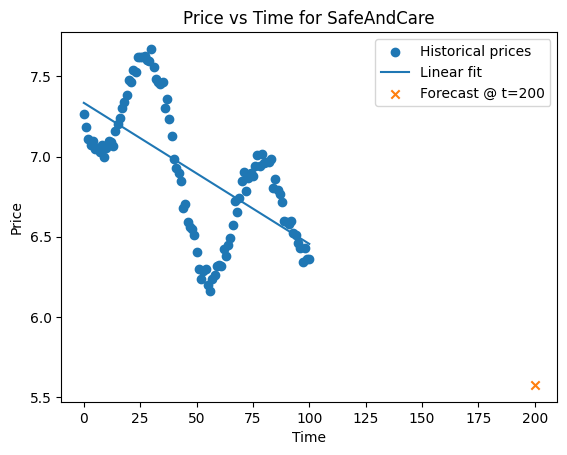

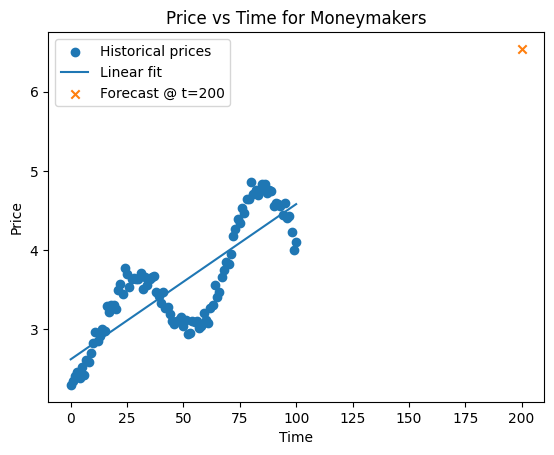

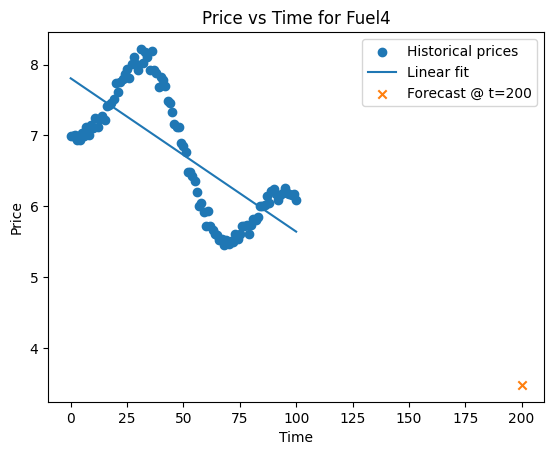

In [38]:
################################################################################
# CELL 4: Illustrate Predictions
#   - Let's plot the linear fit vs. actual data for a couple of assets, just as proof-of-concept.
################################################################################

num_to_plot = min(3, len(asset_names))  # plot a few assets
for i in range(num_to_plot):
    times = np.array(asset_times[i])
    prices = np.array(asset_prices[i])

    # Fit again
    coeffs = np.polyfit(times, prices, deg=1)
    fit_line = np.polyval(coeffs, times)

    plt.figure()
    plt.scatter(times, prices, label="Historical prices")
    plt.plot(times, fit_line, label="Linear fit")

    # We'll also show the predicted price at t=200
    price_200 = np.polyval(coeffs, 200)
    plt.scatter([200], [price_200], marker='x', label="Forecast @ t=200")

    plt.title(f"Price vs Time for {asset_names[i]}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

Build the Markowitz model inputs.
	•	\mu[i] comes from the predicted returns (time=100 to time=200).
	•	\Sigma is estimated from the historical returns from the adjacency in your original price data (0..100).

In [39]:
# Extract expected returns from mean results
expected_returns = predicted_returns
n_assets = len(asset_names)

# Compute covariance matrix using historical data
historical_returns = []
for i, asset in enumerate(asset_names):
    # Get prices during training period
    prices = np.array(asset_prices[i])
    times = np.array(asset_times[i])
    mask = (times >= 0) & (times <= 100)
    asset_prices_train = prices[mask]
    
    # Calculate returns
    asset_returns = np.diff(asset_prices_train) / asset_prices_train[:-1]
    historical_returns.append(asset_returns)

# Ensure all historical returns have the same length
min_length = min(len(returns) for returns in historical_returns)
historical_returns = [returns[:min_length] for returns in historical_returns]
historical_returns = np.array(historical_returns)

# Compute covariance matrix
cov_matrix = np.cov(historical_returns)

# Ensure covariance matrix is positive semi-definite
eigenvalues = np.linalg.eigvalsh(cov_matrix)
if np.any(eigenvalues < 0):
    cov_matrix += np.eye(n_assets) * 1e-8

print("Expected Returns (sample):")
for i in range(min(5, n_assets)):
    print(f"{asset_names[i]}: {expected_returns[i]:.4f}")

print("\nCovariance Matrix (sample):")
print(cov_matrix[:3, :3])

# Find minimum risk portfolio
def solve_min_risk():
    """Find the portfolio with minimum risk"""
    P = matrix(cov_matrix)
    q = matrix(np.zeros(n_assets))
    
    # Constraint: w ≥ 0
    G = matrix(-np.eye(n_assets))
    h = matrix(np.zeros(n_assets))
    
    # Constraint: sum(w) = 1
    A = matrix(np.ones((1, n_assets)))
    b = matrix(np.ones(1))
    
    sol = solvers.qp(P, q, G, h, A, b)
    weights = np.array(sol['x']).flatten()
    port_return = np.dot(weights, expected_returns)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    return weights, port_risk, port_return

# Find maximum return portfolio
def solve_max_return():
    """Find the portfolio with maximum return"""
    c = matrix(-expected_returns)  # Negative because we minimize -r^T w
    
    # Constraint: w ≥ 0
    G = matrix(-np.eye(n_assets))
    h = matrix(np.zeros(n_assets))
    
    # Constraint: sum(w) = 1
    A = matrix(np.ones((1, n_assets)))
    b = matrix(np.ones(1))
    
    sol = solvers.lp(c, G, h, A, b)
    weights = np.array(sol['x']).flatten()
    port_return = np.dot(weights, expected_returns)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    return weights, port_return, port_risk

# Find the extreme portfolios
min_risk_weights, min_risk_value, min_risk_return = solve_min_risk()
max_return_weights, max_return_value, max_return_risk = solve_max_return()

print("\nMinimum Risk Portfolio:")
print(f"Risk: {min_risk_value:.6f}")
print(f"Return: {min_risk_return:.6f}")

print("\nMaximum Return Portfolio:")
print(f"Return: {max_return_value:.6f}")
print(f"Risk: {max_return_risk:.6f}")

Expected Returns (sample):
SafeAndCare: -0.1364
Moneymakers: 0.4283
Fuel4: -0.3834
CPU-XYZ: -0.0205
MarsProject: 0.0796

Covariance Matrix (sample):
[[ 1.01854023e-04  6.69455358e-05 -1.71112855e-05]
 [ 6.69455358e-05  1.24950579e-03  1.45858732e-04]
 [-1.71112855e-05  1.45858732e-04  2.97224717e-04]]

Minimum Risk Portfolio:
Risk: 0.003115
Return: -0.072494

Maximum Return Portfolio:
Return: 0.647062
Risk: 0.071865


Implement the two multi-objective methods:
	•	Weighted Sum Method (WSM): For each \alpha\in[0,1], solve \min \alpha (x^T\Sigma x) - (1-\alpha) (\mu^T x).
	•	Epsilon-Constraint Method (ECM): For each target return r, solve \min x^T\Sigma x subject to \mu^T x \ge r.

WSM found 3 unique solutions
ECM found 10 unique solutions


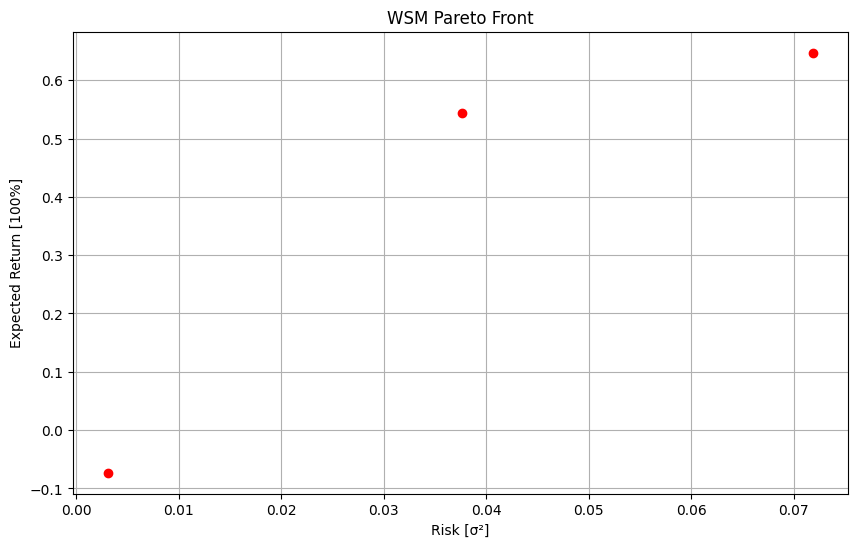

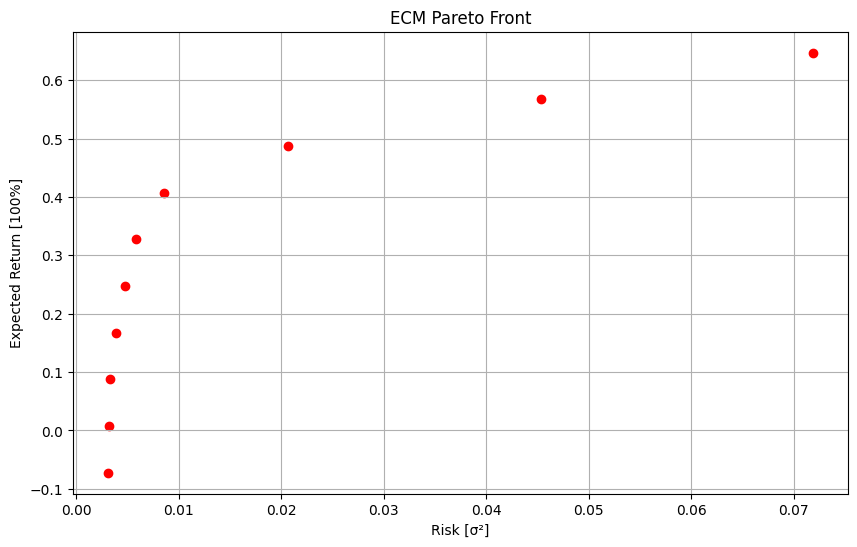

In [40]:
# Weighted Sum Method (WSM)
def weighted_sum_method(n_weights=20, normalize=True):
    # Set up normalization ranges if needed
    if normalize:
        return_range = max_return_value - min_risk_return
        risk_range = max_return_risk - min_risk_value
    
    # Generate weight vectors
    weight_vectors = []
    for i in range(n_weights):
        w_return = i / (n_weights - 1)  # Weight for return
        w_risk = 1 - w_return           # Weight for risk
        weight_vectors.append((w_return, w_risk))
    
    # Solve for each weight vector
    solutions = []
    for w_return, w_risk in weight_vectors:
        # Setup quadratic programming parameters
        P = matrix(cov_matrix)
        q = matrix(np.zeros(n_assets))
        
        if normalize:
            # For normalized objective function
            q_mod = matrix(-w_return * expected_returns / return_range)
            P_mod = matrix(w_risk * cov_matrix / risk_range)
        else:
            # For non-normalized objective function
            q_mod = matrix(-w_return * expected_returns)
            P_mod = matrix(w_risk * cov_matrix)
        
        # Constraint: w ≥ 0
        G = matrix(-np.eye(n_assets))
        h = matrix(np.zeros(n_assets))
        
        # Constraint: sum(w) = 1
        A = matrix(np.ones((1, n_assets)))
        b = matrix(np.ones(1))
        
        # Solve QP
        sol = solvers.qp(P_mod, q_mod, G, h, A, b)
        
        if sol['status'] != 'optimal':
            print(f"Warning: Optimization did not reach an optimal solution for weights {w_return}, {w_risk}. Status: {sol['status']}")
            continue
        
        weights = np.array(sol['x']).flatten()
        port_return = np.dot(weights, expected_returns)
        port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        solutions.append((weights, port_return, port_risk))
    
    # Filter duplicate solutions
    unique_solutions = []
    for sol in solutions:
        is_unique = True
        for existing_sol in unique_solutions:
            if (np.abs(sol[1] - existing_sol[1]) < 1e-6 and 
                np.abs(sol[2] - existing_sol[2]) < 1e-6):
                is_unique = False
                break
        if is_unique:
            unique_solutions.append(sol)
    
    return unique_solutions

# Epsilon-Constraint Method (ECM)
def epsilon_constraint_method(n_thresholds=20):
    """
    Implements the Epsilon-Constraint Method for portfolio optimization.
    
    Args:
        n_thresholds: Number of threshold values to use
    
    Returns:
        List of Pareto optimal solutions (weights, return, risk)
    """
    # Generate threshold values
    thresholds = []
    for i in range(n_thresholds):
        t = min_risk_return + (i / (n_thresholds - 1)) * (max_return_value - min_risk_return)
        thresholds.append(t)
    
    # Solve for each threshold
    solutions = []
    for threshold in thresholds:
        # Setup quadratic programming parameters
        P = matrix(cov_matrix)
        q = matrix(np.zeros(n_assets))
        
        # Constraint: w ≥ 0
        G = matrix(-np.eye(n_assets))
        h = matrix(np.zeros(n_assets))
        
        # Constraints: sum(w) = 1 and r^T w >= threshold
        A = matrix(np.vstack((
            np.ones(n_assets),     # sum(w) = 1
            expected_returns       # r^T w >= threshold
        )))
        b = matrix(np.array([1.0, threshold]))
        
        # Solve QP
        sol = solvers.qp(P, q, G, h, A, b)
        
        if sol['status'] != 'optimal':
            print(f"Warning: Optimization did not reach an optimal solution for threshold {threshold}. Status: {sol['status']}")
            continue
        
        weights = np.array(sol['x']).flatten()
        port_return = np.dot(weights, expected_returns)
        port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        solutions.append((weights, port_return, port_risk))
    
    # Filter duplicate solutions
    unique_solutions = []
    for sol in solutions:
        is_unique = True
        for existing_sol in unique_solutions:
            if (np.abs(sol[1] - existing_sol[1]) < 1e-6 and 
                np.abs(sol[2] - existing_sol[2]) < 1e-6):
                is_unique = False
                break
        if is_unique:
            unique_solutions.append(sol)
    
    return unique_solutions

# Function to plot Pareto front
def plot_pareto_front(solutions, title):
    risks = [sol[2] for sol in solutions]
    returns = [sol[1] for sol in solutions]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(risks, returns, c='red', marker='o')
    plt.xlabel('Risk [σ²]')
    plt.ylabel('Expected Return [100%]')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Test the methods with a small number of points
wsm_solutions = weighted_sum_method(10)
ecm_solutions = epsilon_constraint_method(10)

print(f"WSM found {len(wsm_solutions)} unique solutions")
print(f"ECM found {len(ecm_solutions)} unique solutions")

plot_pareto_front(wsm_solutions, "WSM Pareto Front")
plot_pareto_front(ecm_solutions, "ECM Pareto Front")

	•	Run both WSM and ECM with different numbers of sample points (e.g., num_points=5,11,21,51).
	•	Plot the resulting Pareto fronts.
	•	Compare how many unique solutions each approach yields (some alphas can produce the same optimum).

Running with 10 points...
  WSM found 3 unique solutions
  ECM found 10 unique solutions
Running with 20 points...
  WSM found 6 unique solutions
  ECM found 20 unique solutions
Running with 50 points...
  WSM found 12 unique solutions
  ECM found 50 unique solutions
Running with 100 points...
  WSM found 22 unique solutions
  ECM found 100 unique solutions
Running with 200 points...
  WSM found 43 unique solutions
  ECM found 200 unique solutions


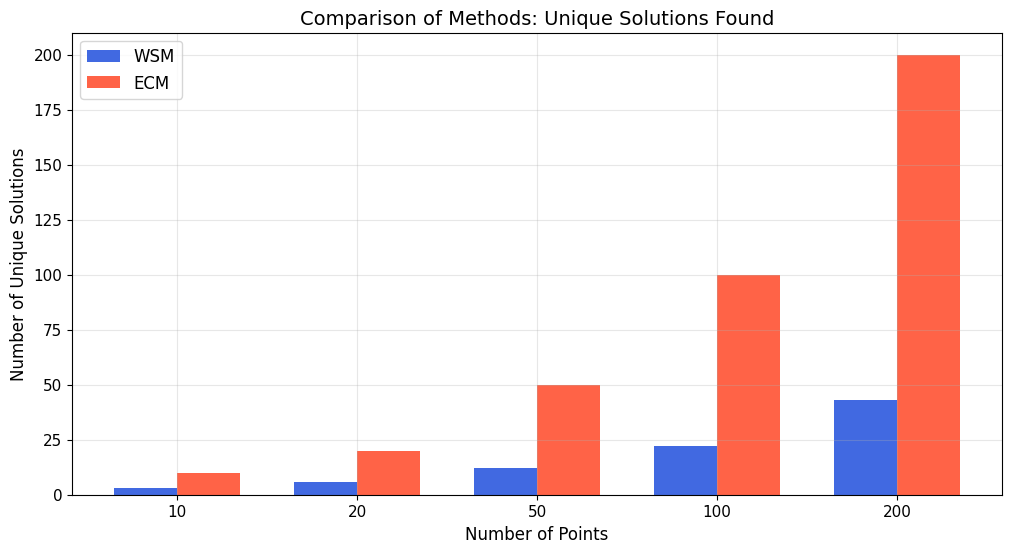

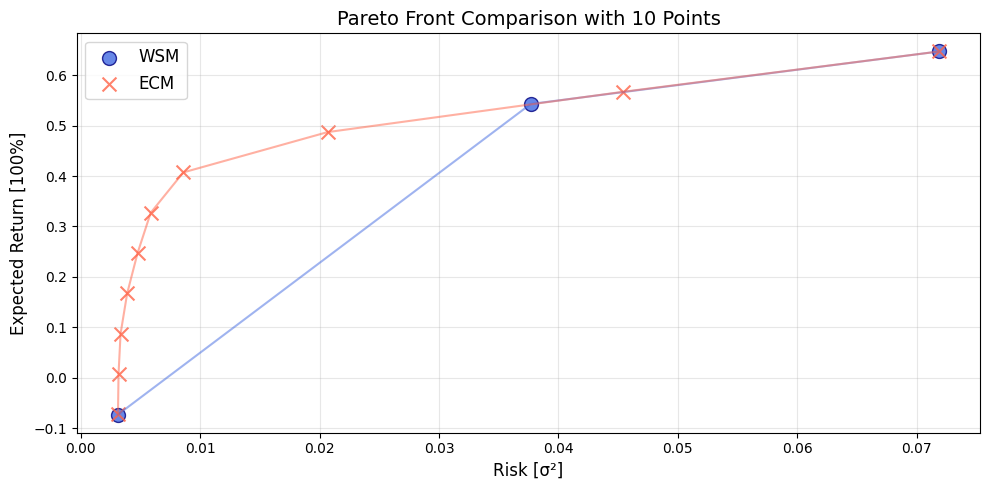

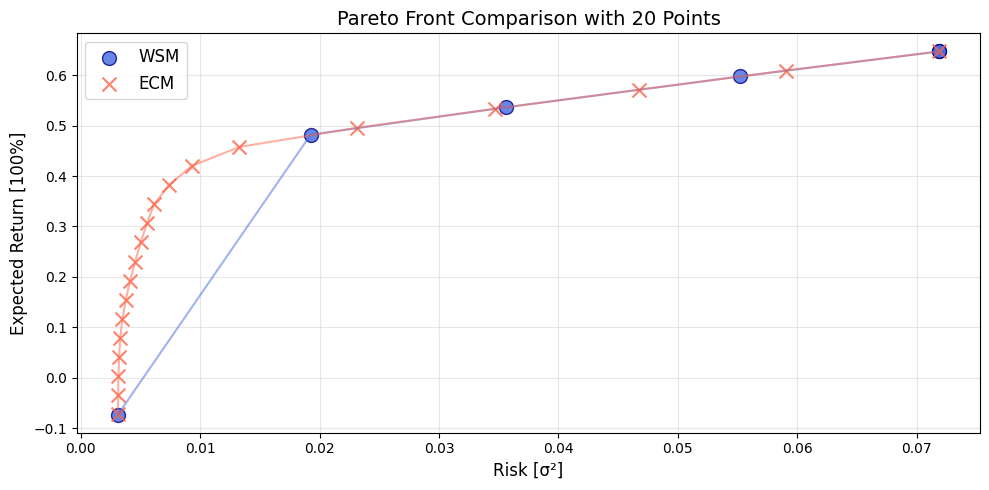

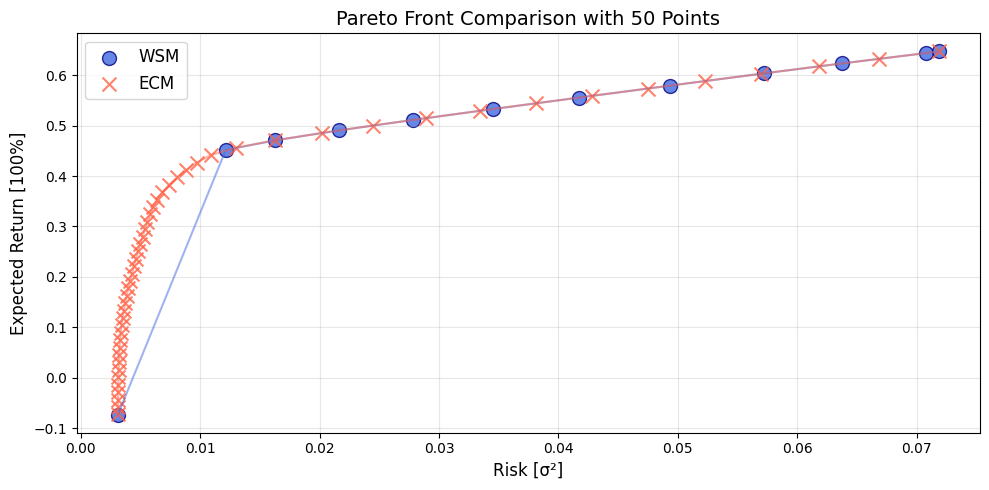

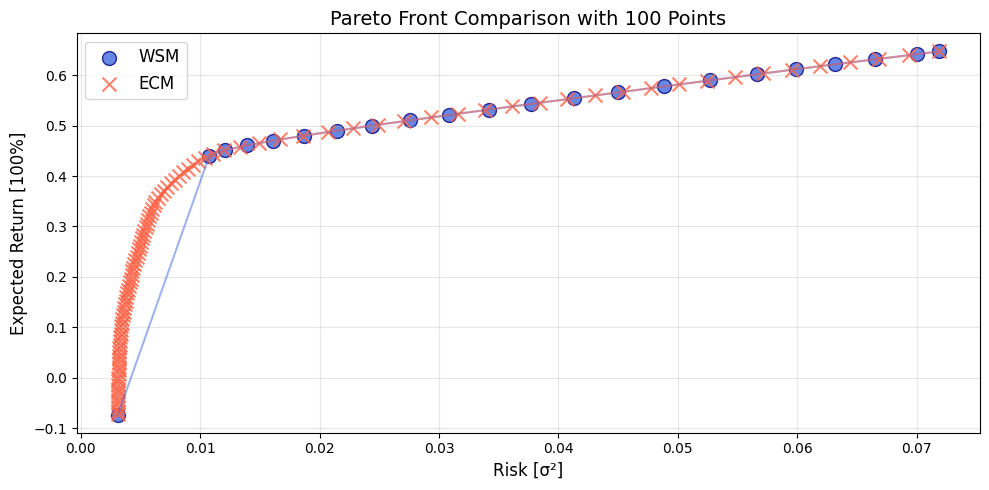

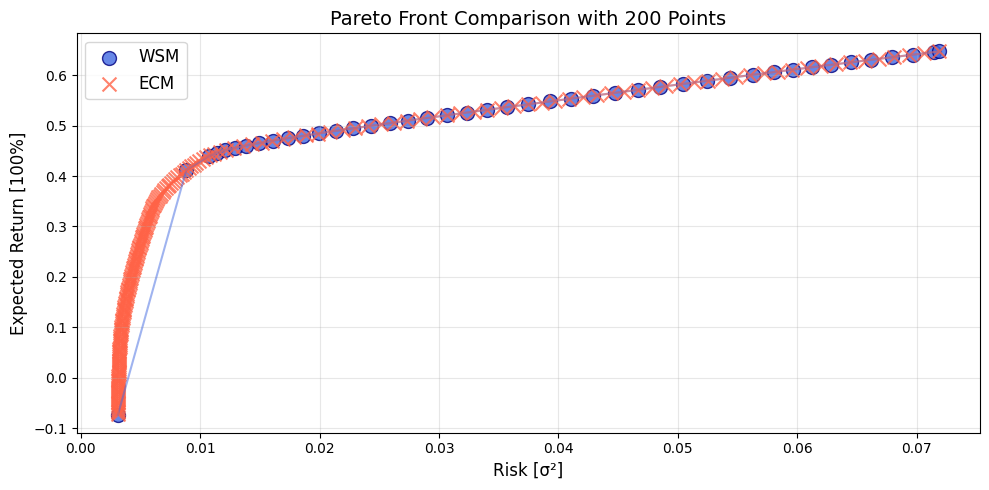

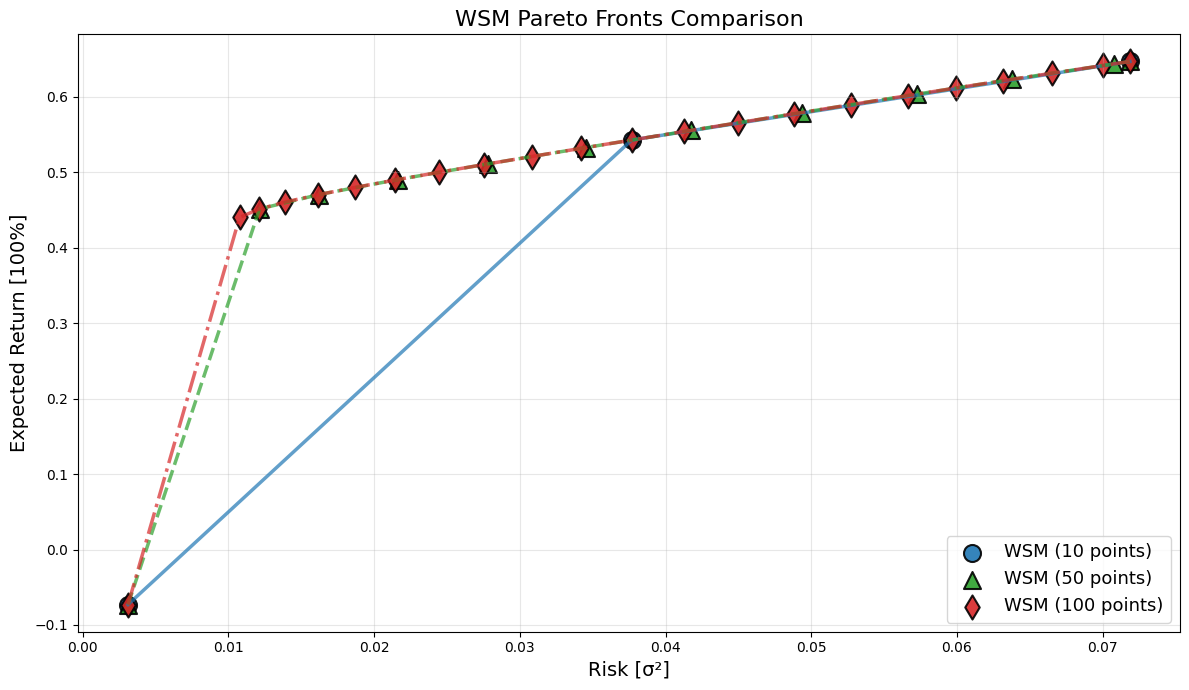

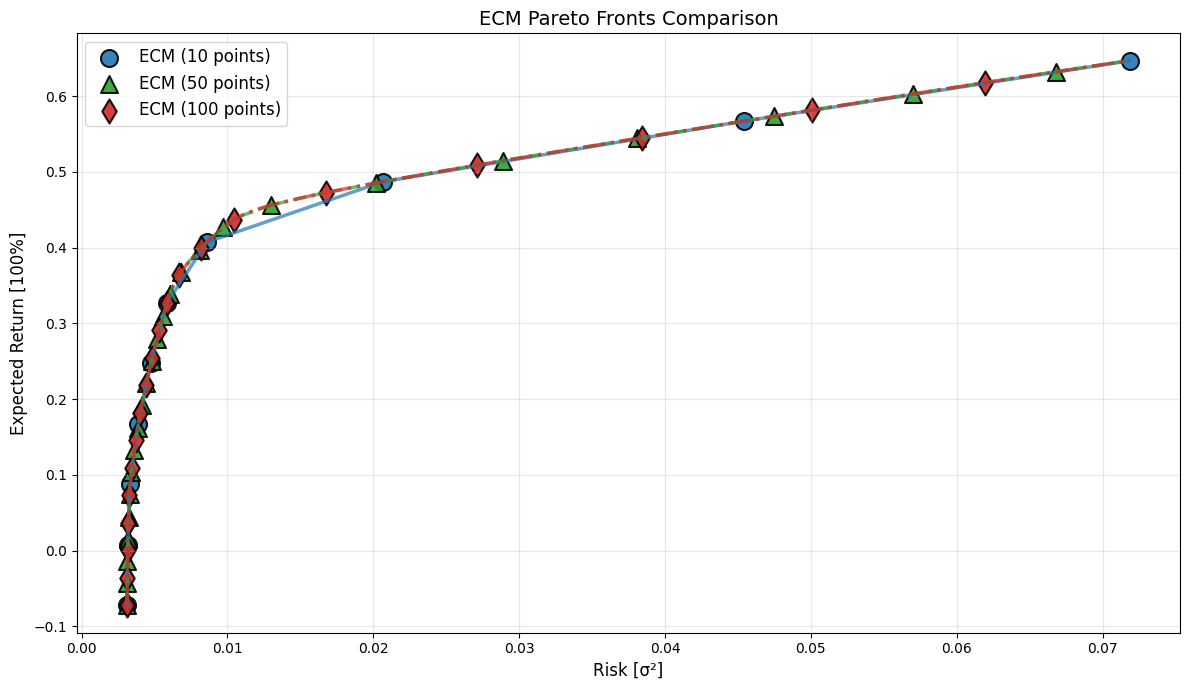

In [41]:
# Run WSM and ECM with different numbers of weight vectors/thresholds
point_counts = [10, 20, 50, 100, 200]
wsm_results = {}
ecm_results = {}

# Define different markers for each point count
markers = {
    10: 'o',    # circle
    20: 's',    # square
    50: '^',    # triangle up
    100: 'd',   # diamond
    200: 'p'    # pentagon
}

# Colors for each point count
colors = {
    10: '#1f77b4',    # blue
    20: '#ff7f0e',    # orange
    50: '#2ca02c',    # green
    100: '#d62728',   # red
    200: '#9467bd'    # purple
}

# Suppress solver output
solvers.options['show_progress'] = False

for count in point_counts:
    print(f"Running with {count} points...")
    
    # Run WSM with normalization
    wsm_solutions = weighted_sum_method(count, normalize=True)
    wsm_results[count] = {
        'solutions': wsm_solutions,
        'unique_count': len(wsm_solutions)
    }
    
    # Run ECM
    ecm_solutions = epsilon_constraint_method(count)
    ecm_results[count] = {
        'solutions': ecm_solutions,
        'unique_count': len(ecm_solutions)
    }
    
    print(f"  WSM found {len(wsm_solutions)} unique solutions")
    print(f"  ECM found {len(ecm_solutions)} unique solutions")

# Bar chart for number of unique solutions
plt.figure(figsize=(12, 6))
x = np.arange(len(point_counts))
width = 0.35

wsm_counts = [wsm_results[c]['unique_count'] for c in point_counts]
ecm_counts = [ecm_results[c]['unique_count'] for c in point_counts]

plt.bar(x - width/2, wsm_counts, width, label='WSM', color='royalblue')
plt.bar(x + width/2, ecm_counts, width, label='ECM', color='tomato')

plt.xlabel('Number of Points', fontsize=12)
plt.ylabel('Number of Unique Solutions', fontsize=12)
plt.title('Comparison of Methods: Unique Solutions Found', fontsize=14)
plt.xticks(x, point_counts, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Create separate plots for each point count
for count in point_counts:
    plt.figure(figsize=(10, 5))
    
    wsm_solutions = wsm_results[count]['solutions']
    ecm_solutions = ecm_results[count]['solutions']
    
    wsm_risks = [sol[2] for sol in wsm_solutions]
    wsm_returns = [sol[1] for sol in wsm_solutions]
    
    ecm_risks = [sol[2] for sol in ecm_solutions]
    ecm_returns = [sol[1] for sol in ecm_solutions]
    
    plt.scatter(wsm_risks, wsm_returns, marker='o', s=100, label='WSM', color='royalblue', alpha=0.8, edgecolors='navy')
    plt.scatter(ecm_risks, ecm_returns, marker='x', s=100, label='ECM', color='tomato', alpha=0.8)
    
    # Add connecting lines to show the fronts more clearly
    wsm_points = sorted(zip(wsm_risks, wsm_returns), key=lambda x: x[0])
    ecm_points = sorted(zip(ecm_risks, ecm_returns), key=lambda x: x[0])
    
    if wsm_points:
        wsm_x, wsm_y = zip(*wsm_points)
        plt.plot(wsm_x, wsm_y, '-', color='royalblue', alpha=0.5)
    
    if ecm_points:
        ecm_x, ecm_y = zip(*ecm_points)
        plt.plot(ecm_x, ecm_y, '-', color='tomato', alpha=0.5)
    
    plt.xlabel('Risk [σ²]', fontsize=12)
    plt.ylabel('Expected Return [100%]', fontsize=12)
    plt.title(f'Pareto Front Comparison with {count} Points', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
    plt.show()

# Combined plot with WSM only (to see its progression better)
plt.figure(figsize=(12, 7))

# Use fewer points for clarity - just use 10, 50, and 100 points
selected_counts = [10, 50, 100]
line_styles = {10: '-', 50: '--', 100: '-.'}

for count in selected_counts:
    solutions = wsm_results[count]['solutions']
    risks = [sol[2] for sol in solutions]
    returns = [sol[1] for sol in solutions]
    
    # Connect points for better visualization
    points = sorted(zip(risks, returns), key=lambda x: x[0])
    if points:
        x_vals, y_vals = zip(*points)
        
        # Use larger, more distinct markers and plot fewer of them (every nth point)
        n = max(1, len(x_vals) // 20)
        plt.scatter(x_vals[::n], y_vals[::n], s=150, label=f'WSM ({count} points)', 
                   color=colors[count], marker=markers[count], alpha=0.9, edgecolors='black', linewidth=1.5)
        
        # Use different line styles for different point counts
        plt.plot(x_vals, y_vals, line_styles[count], color=colors[count], 
                alpha=0.7, linewidth=2.5)

plt.xlabel('Risk [σ²]', fontsize=14)
plt.ylabel('Expected Return [100%]', fontsize=14)
plt.title('WSM Pareto Fronts Comparison', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=13, loc='lower right')
plt.tight_layout()
plt.show()

# Combined plot with ECM only (to see its progression better)
plt.figure(figsize=(12, 7))

for count in selected_counts:
    solutions = ecm_results[count]['solutions']
    risks = [sol[2] for sol in solutions]
    returns = [sol[1] for sol in solutions]
    
    # Connect points for better visualization
    points = sorted(zip(risks, returns), key=lambda x: x[0])
    if points:
        x_vals, y_vals = zip(*points)
        
        # Use larger, more distinct markers and plot fewer of them
        n = max(1, len(x_vals) // 20)
        plt.scatter(x_vals[::n], y_vals[::n], s=150, label=f'ECM ({count} points)', 
                   color=colors[count], marker=markers[count], alpha=0.9, edgecolors='black', linewidth=1.5)
        
        # Use different line styles for different point counts
        plt.plot(x_vals, y_vals, line_styles[count], color=colors[count], 
                alpha=0.7, linewidth=2.5)

plt.xlabel('Risk [σ²]', fontsize=12)
plt.ylabel('Expected Return [100%]', fontsize=12)
plt.title('ECM Pareto Fronts Comparison', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Interpretation of the Pareto Plots and Unique Solutions

1. **Plot Description**  
   - The *x-axis* represents the **portfolio risk** (variance). Lower values mean less risk.  
   - The *y-axis* represents the **portfolio return** predicted by the model. Higher values mean higher return.  
   - Each marker represents a different **optimal portfolio** found by the optimization method (Weighted Sum or Epsilon-Constraint).

2. **Weighted Sum Method (WSM)**  
   - We vary the parameter \(\alpha \in [0,1]\) in discrete steps (e.g., 5, 11, 21, 51).  
   - For each \(\alpha\), the model tries to minimize \(\alpha \times \text{risk} - (1-\alpha)\times \text{return}\).  
   - The reported *unique* solutions are those with distinct \((\text{risk}, \text{return})\) pairs.  
   - In the figure, you see fewer points when using fewer \(\alpha\)-steps because multiple \(\alpha\) values can produce the *same* portfolio.  
   - As you increase the number of \(\alpha\)-steps, you typically discover more unique points on the Pareto front.  

3. **Epsilon-Constraint Method (ECM)**  
   - We vary a target return \(r\) and minimize \(\text{risk}\) subject to \(\text{return} \ge r\).  
   - The red “x” markers in the plot show the ECM solutions for 11 target-return steps.  
   - Notice these solutions can span a somewhat different shape or distribution than WSM because the Pareto frontier is sampled by fixing \(\text{return}\) rather than weighting risk/return directly.

4. **Observations & Conclusions**  
   - Both methods identify *efficient (Pareto-optimal) portfolios*: each point is a valid trade-off between risk and return.  
   - **WSM solutions** can “bunch up” in some regions if those risk/return objectives lead to the same optimum. Increasing the number of \(\alpha\) steps from 5 to 51 yields more unique portfolios.  
   - **ECM solutions** for 11 steps may yield a different coverage of the front.  
   - Comparing the two sets of solutions shows that the Pareto front has a characteristic shape where risk increases to achieve higher returns.  
   - Generally, you can see which **method** (and how many sampling steps) is more effective in covering the front thoroughly.  

5. **Next Steps**  
   - If you need a denser approximation, increase the number of steps (either \(\alpha\)-steps for WSM or return-target steps for ECM).  
   - If you see identical solutions repeated, that indicates multiple parameter values converge to the same optimum.  
   - You can also combine these two approaches or adopt more sophisticated sampling methods (e.g., binary search on returns, or multi-objective evolutionary algorithms) to capture the frontier more completely.

## Portfolio Game

Return threshold (median): 0.361409

Selected MinRisk Portfolio (from ECM):
Expected Return: 0.365025
Expected Risk: 0.006733
Sharpe Ratio: 54.218198
Strategy: Minimum risk with above-median return
Sum of weights: 1.0000000000000002


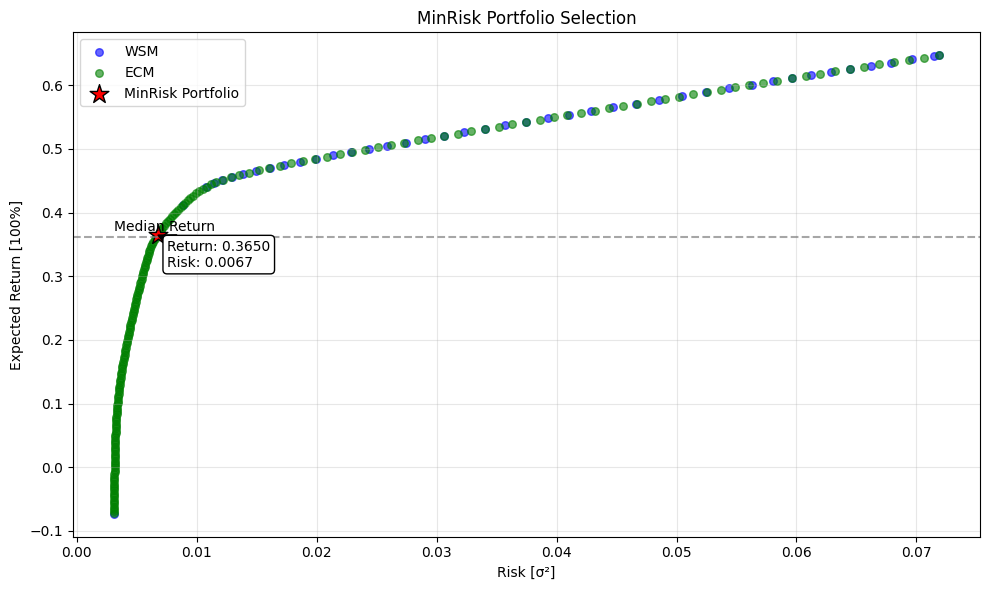

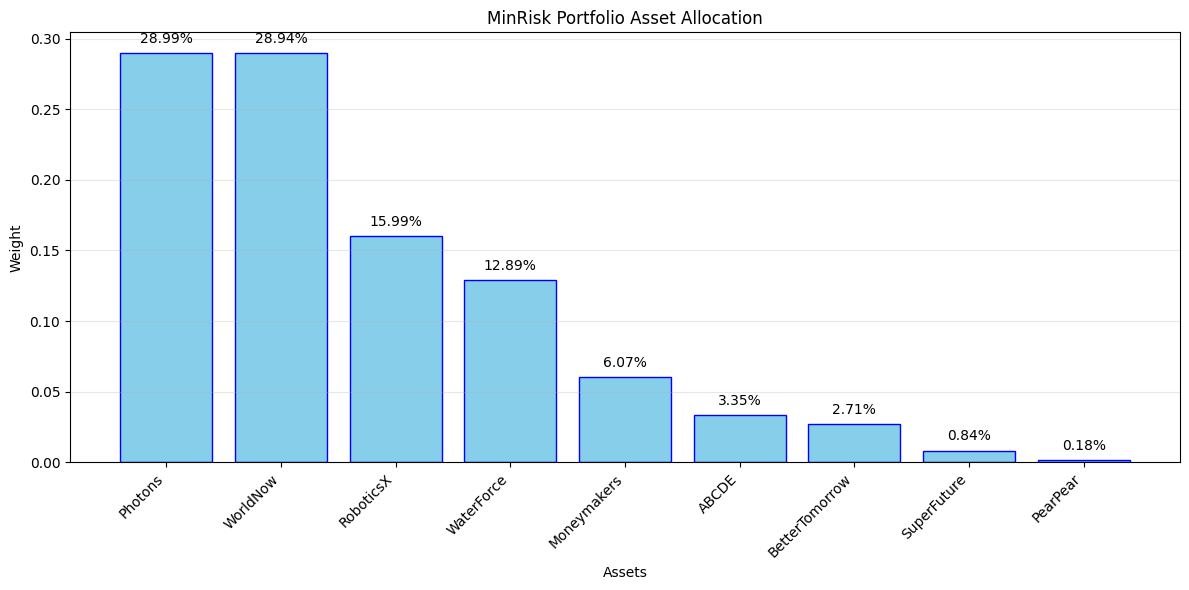

Portfolio saved to 151958_151960.txt


In [42]:
# Define the asset names in the correct order
asset_names_ordered = [
    "SuperFuture", "Apples", "WorldNow", "Electronics123", "Photons",
    "SpaceNow", "PearPear", "PositiveCorrelation", "BetterTechnology", "ABCDE",
    "EnviroLike", "Moneymakers", "Fuel4", "MarsProject", "CPU-XYZ",
    "RoboticsX", "Lasers", "WaterForce", "SafeAndCare", "BetterTomorrow"
]

# Combine solutions from both methods for a more comprehensive Pareto front
wsm_solutions = wsm_results[200]['solutions']
ecm_solutions = ecm_results[200]['solutions']
all_solutions = wsm_solutions + ecm_solutions

# Analyze the risk and return characteristics of all portfolios
risks = [sol[2] for sol in all_solutions]
returns = [sol[1] for sol in all_solutions]

# Calculate return threshold (median return)
return_50th = np.percentile(returns, 50)
print(f"Return threshold (median): {return_50th:.6f}")

# Find MinRisk portfolio with above-median return
selected_idx = -1
min_risk_value = float('inf')

for i, (weights, port_return, port_risk) in enumerate(all_solutions):
    if port_return > return_50th and port_risk < min_risk_value:
        min_risk_value = port_risk
        selected_idx = i

# Get the selected portfolio
selected_weights, selected_return, selected_risk = all_solutions[selected_idx]
selected_source = "WSM" if selected_idx < len(wsm_solutions) else "ECM"
selected_sharpe = selected_return / selected_risk if selected_risk > 0 else 0

print(f"\nSelected MinRisk Portfolio (from {selected_source}):")
print(f"Expected Return: {selected_return:.6f}")
print(f"Expected Risk: {selected_risk:.6f}")
print(f"Sharpe Ratio: {selected_sharpe:.6f}")
print(f"Strategy: Minimum risk with above-median return")

# Map weights to the correct order
portfolio_weights = {}
for i, weight in enumerate(selected_weights):
    portfolio_weights[asset_names[i]] = weight

# Create ordered weights list
ordered_weights = []
for asset in asset_names_ordered:
    if asset in portfolio_weights:
        ordered_weights.append(portfolio_weights[asset])
    else:
        ordered_weights.append(0.0)

# Assert weights sum to 1
sum_weights = sum(ordered_weights)
assert abs(sum_weights - 1.0) < 1e-10, f"Portfolio weights must sum to 1.0. Current sum: {sum_weights}"

print(f"Sum of weights: {sum(ordered_weights)}")

# Plot the Pareto fronts with the selected portfolio
plt.figure(figsize=(10, 6))

# Plot each method's front
plt.scatter([sol[2] for sol in wsm_solutions], [sol[1] for sol in wsm_solutions], 
           c='blue', s=30, alpha=0.6, label='WSM')
plt.scatter([sol[2] for sol in ecm_solutions], [sol[1] for sol in ecm_solutions], 
           c='green', s=30, alpha=0.6, label='ECM')

# Highlight the selected portfolio
plt.scatter([selected_risk], [selected_return], c='red', s=200, marker='*', 
            edgecolors='black', linewidth=1, label='MinRisk Portfolio')

# Add a horizontal line at the median return
plt.axhline(y=return_50th, color='grey', linestyle='--', alpha=0.7)
plt.text(min(risks), return_50th+0.01, 'Median Return', fontsize=10)

# Add annotation for the selected portfolio
plt.annotate(f"Return: {selected_return:.4f}\nRisk: {selected_risk:.4f}",
             xy=(selected_risk, selected_return), 
             xytext=(selected_risk+0.0008, selected_return-0.05),
             arrowprops=dict(facecolor='black', shrink=0.05),
             bbox=dict(boxstyle="round", fc="white"))

plt.xlabel('Risk [σ²]')
plt.ylabel('Expected Return [100%]')
plt.title('MinRisk Portfolio Selection')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Create a bar chart of the portfolio weights
plt.figure(figsize=(12, 6))

# Get non-zero weights and sort by weight
asset_weight_pairs = [(asset, weight) for asset, weight in zip(asset_names_ordered, ordered_weights) 
                     if weight > 0.001]
asset_weight_pairs.sort(key=lambda x: x[1], reverse=True)
sorted_assets = [pair[0] for pair in asset_weight_pairs]
sorted_weights = [pair[1] for pair in asset_weight_pairs]

# Create bar chart
bars = plt.bar(sorted_assets, sorted_weights, color='skyblue', edgecolor='blue')

# Add weight values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.2%}', ha='center', va='bottom')

plt.xlabel('Assets')
plt.ylabel('Weight')
plt.title('MinRisk Portfolio Asset Allocation')
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Save the portfolio to a file
output_filename = "151958_151960.txt"
with open(output_filename, 'w') as f:
    f.write(f"{selected_return:.6f} {selected_risk:.6f}")
    for weight in ordered_weights:
        f.write(f" {weight:.6f}")

print(f"Portfolio saved to {output_filename}")